# Introduction

Our project is about spoiler classification in book reviews. Our dataset is based on book reviews from www.goodreads.com. We frame the problem as a sentence-level binary classification task: given a sentence in a review, we aim to predict if it contains spoilers or not.

Our best performing model is logistic regression. Starting from the original dataset, we provide an end-to-end walkthrough of the same below.

# Install/Import Packages

In [ ]:
# We install the sentence-transformers package to generate 
# dense embeddings for sentences.
!pip install sentence-transformers

In [ ]:
from collections import defaultdict
from google.colab import drive
import imblearn
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns; sns.set_style("ticks")
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm; tqdm.pandas()
from wordcloud import WordCloud

# Data Preprocessing & Feature Engineering

The  original dataset is review-level i.e. one review per row. We convert the dataset to sentence-level ie. one review sentence per row.

In [ ]:
# Load original dataset
!gdown --id ########## Put ID here ##########

In [ ]:
df = pd.read_json(
    path_or_buf="/content/goodreads_reviews_spoiler.json", 
    lines=True
)
df.head(5)

In [ ]:
# review_id, user_id, and book_id are in string format. We convert them to a 
# numeric format for space saving.
df.review_id = LabelEncoder().fit_transform(df.review_id)
df.user_id = LabelEncoder().fit_transform(df.user_id)
df.book_id = LabelEncoder().fit_transform(df.book_id)

In [ ]:
# Convert dataset from review-level to sentence-level
cache = defaultdict(list)

for i in tqdm(range(len(df))):
    _pos_sentence, _num_sentences = 0, len(df.review_sentences.iloc[i])
    
    for is_spoiler, sentence in df.review_sentences.iloc[i]:
        cache["timestamp"].append(df.timestamp.iloc[i])
        cache["review_id"].append(df.review_id.iloc[i])
        cache["user_id"].append(df.user_id.iloc[i])
        cache["book_id"].append(df.book_id.iloc[i])
        cache["review_rating"].append(df.rating.iloc[i])
        cache["is_spoiler"].append(is_spoiler)
        cache["sentence"].append(str(sentence))
        cache["_pos_sentence"].append(_pos_sentence)
        _pos_sentence += 1
        cache["_num_sentences"].append(_num_sentences)

# Save sentence-level dataset
drive.mount('drive')
pd.DataFrame(data=cache).to_csv("data.csv")
!cp data.csv "drive/My Drive/"

We load the sentence-level dataset, perform some preprocessing, create sentence embeddings, and split the data into train/val/test sets.

In [ ]:
# Load sentence-level dataset
!gdown ########## Put ID here ##########

In [ ]:
df = pd.read_csv(filepath_or_buffer="/content/data.csv")
df.head(5)

In [ ]:
# Drop unnamed column
df.drop(columns=["Unnamed: 0"], inplace=True)

# Drop rows with missing values
print(df.isnull().sum())
df.dropna(inplace=True)

# Drop sentences that have been marked as both spoilers and not-spoilers
spoiler_sentences = set(df.sentence[df.is_spoiler == 1])
not_spoiler_sentences = set(df.sentence[df.is_spoiler == 0])

df["flag"] = df.sentence.apply(
    lambda s: not ((s in spoiler_sentences) and (s in not_spoiler_sentences))
)
df = df[df.flag]

df.drop(columns=["flag"], inplace=True)

In [ ]:
# Truncate dataset to reduce computational/storage requirements
# Use random sampling to preserve class distributions
df_trunc = df.sample(n=199000, random_state=42, ignore_index=True)

In [ ]:
# Create pretrained sentence embeddings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentence_transformer = SentenceTransformer(
    model_name_or_path="all-MiniLM-L6-v2", device=device
)
embeddings = sentence_transformer.encode(
    sentences=df_trunc.sentence.values, 
    show_progress_bar=True, 
    convert_to_numpy=True, 
    device=device
)
df_trunc["sentence_embedding"] = pd.Series(list(embeddings))

In [ ]:
# Split dataset into train/val/test datasets
X_train, X_test_, y_train, y_test_ = train_test_split(
    df_trunc.loc[:, df_trunc.columns != "is_spoiler"], 
    df_trunc["is_spoiler"], 
    train_size=99000, 
    test_size=100000, 
    random_state=42, 
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_, 
    y_test_, 
    train_size=50000, 
    test_size=50000, 
    random_state=42, 
    shuffle=True
)

# Save datasets
drive.mount("drive")
X_train.to_pickle("X_train.pkl")
!cp X_train.pkl "drive/My Drive/"
X_val.to_pickle("X_val.pkl")
!cp X_val.pkl "drive/My Drive/"
X_test.to_pickle("X_test.pkl")
!cp X_test.pkl "drive/My Drive/"
y_train.to_pickle("y_train.pkl")
!cp y_train.pkl "drive/My Drive/"
y_val.to_pickle("y_val.pkl")
!cp y_val.pkl "drive/My Drive/"
y_test.to_pickle("y_test.pkl")
!cp y_test.pkl "drive/My Drive/"

We load the train/val/test sets, perform feature engineering, and setup the data to be used for training.

In [ ]:
# Load train/val/test datasets
!gdown ########## Put ID here ########## # X_train
!gdown ########## Put ID here ########## # X_val
!gdown ########## Put ID here ########## # X_test
!gdown ########## Put ID here ########## # y_train
!gdown ########## Put ID here ########## # y_val
!gdown ########## Put ID here ########## # y_test

In [ ]:
X_train = pd.read_pickle(filepath_or_buffer="/content/X_train.pkl")
y_train = pd.read_pickle(filepath_or_buffer="/content/y_train.pkl")
X_val = pd.read_pickle(filepath_or_buffer="/content/X_val.pkl")
y_val = pd.read_pickle(filepath_or_buffer="/content/y_val.pkl")
X_test = pd.read_pickle(filepath_or_buffer="/content/X_test.pkl")
y_test = pd.read_pickle(filepath_or_buffer="/content/y_test.pkl")

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_test = pd.DataFrame(y_test)

In addition to our pretrained sentence embeddings, we generate two additional features :- the relative position of the sentence in a review (i.e. the index of the sentence in the review divided by the no. of sentences in the review), and the log of the length of the sentence in characters.

In [ ]:
# Relative position of the sentence in the review
X_train["_rel_pos_sentence"] = X_train._pos_sentence / X_train._num_sentences
X_val["_rel_pos_sentence"] = X_val._pos_sentence / X_val._num_sentences
X_test["_rel_pos_sentence"] = X_test._pos_sentence / X_test._num_sentences

# Log of the no. of characters in the sentence
X_train["_len_sentence"] = X_train.sentence.apply(lambda s: len(s))
X_val["_len_sentence"] = X_val.sentence.apply(lambda s: len(s))
X_test["_len_sentence"] = X_test.sentence.apply(lambda s: len(s))
X_train["_len_sentence_log"] = X_train._len_sentence.apply(lambda x: np.log(x))
X_val["_len_sentence_log"] = X_val._len_sentence.apply(lambda x: np.log(x))
X_test["_len_sentence_log"] = X_test._len_sentence.apply(lambda x: np.log(x))

In [ ]:
# Create feature array of sentence embeddings, relative positions of sentences, 
# and logs of lengths of sentences

X_train_sentence_embedding = np.array(X_train.sentence_embedding.tolist())
X_val_sentence_embedding = np.array(X_val.sentence_embedding.tolist())
X_test_sentence_embedding = np.array(X_test.sentence_embedding.tolist())

X_train_values = np.hstack(
    tup=(
        np.array(X_train.sentence_embedding.tolist()), 
        np.expand_dims(X_train._rel_pos_sentence.values, axis=1),
        np.expand_dims(X_train._len_sentence_log.values, axis=1),
    )
)

X_val_values = np.hstack(
    tup=(
        np.array(X_val.sentence_embedding.tolist()), 
        np.expand_dims(X_val._rel_pos_sentence.values, axis=1),
        np.expand_dims(X_val._len_sentence_log.values, axis=1),
    )
)

X_test_values = np.hstack(
    tup=(
        np.array(X_test.sentence_embedding.tolist()), 
        np.expand_dims(X_test._rel_pos_sentence.values, axis=1),
        np.expand_dims(X_test._len_sentence_log.values, axis=1),
    )
)

y_train_values = y_train.values.ravel()
y_val_values = y_val.values.ravel()
y_test_values = y_test.values.ravel()

# Data Exploration

In [ ]:
df = pd.concat(
    [
        pd.concat([X_train, X_val, X_test], axis=0, ignore_index=True), 
        pd.concat([y_train, y_val, y_test], axis=0, ignore_index=True)
    ], axis=1
)

### Summary Statistics

The following is a summary of our dataset. We note that our dataset suffers from a class imbalance problem, with only ~3% of the sentences being spoilers.

No. of reviews              : 172,004
No. of users                : 15,605
No. of books                : 23,450
No. of sentences            : 199,000
% of sentences with spoilers: 3.16%



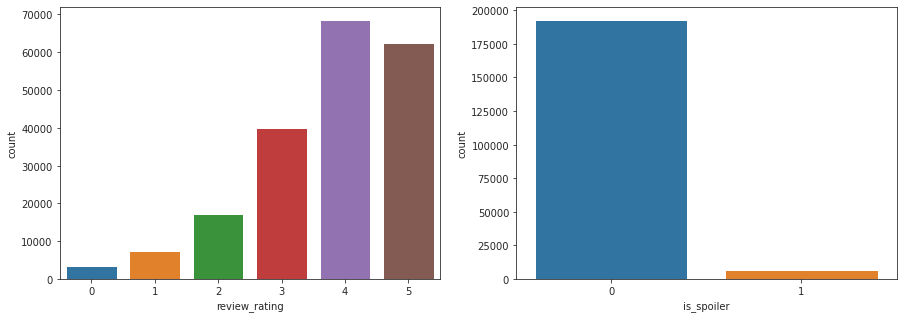

In [ ]:
print(f"No. of reviews              : {df.review_id.nunique():,}")
print(f"No. of users                : {df.user_id.nunique():,}")
print(f"No. of books                : {df.book_id.nunique():,}")
print(f"No. of sentences            : {len(df):,}")
print(f"% of sentences with spoilers: {round(df.is_spoiler.sum() * 100 / len(df), 2)}%\n")

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df.review_rating, ax=ax[0])
sns.countplot(x=df.is_spoiler, ax=ax[1])
fig.show()

### is_spoiler vs. review_rating

The following plot suggests that there is no discernible difference between not spoiler and spoiler sentences on the basis of review ratings

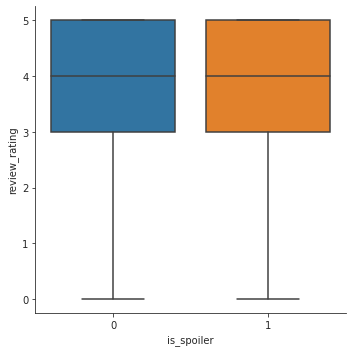

In [ ]:
sns.catplot(data=df, x="is_spoiler", y="review_rating", kind="box")

### Wordclouds of not spoiler/spoiler sentences

([], <a list of 0 Text major ticklabel objects>)

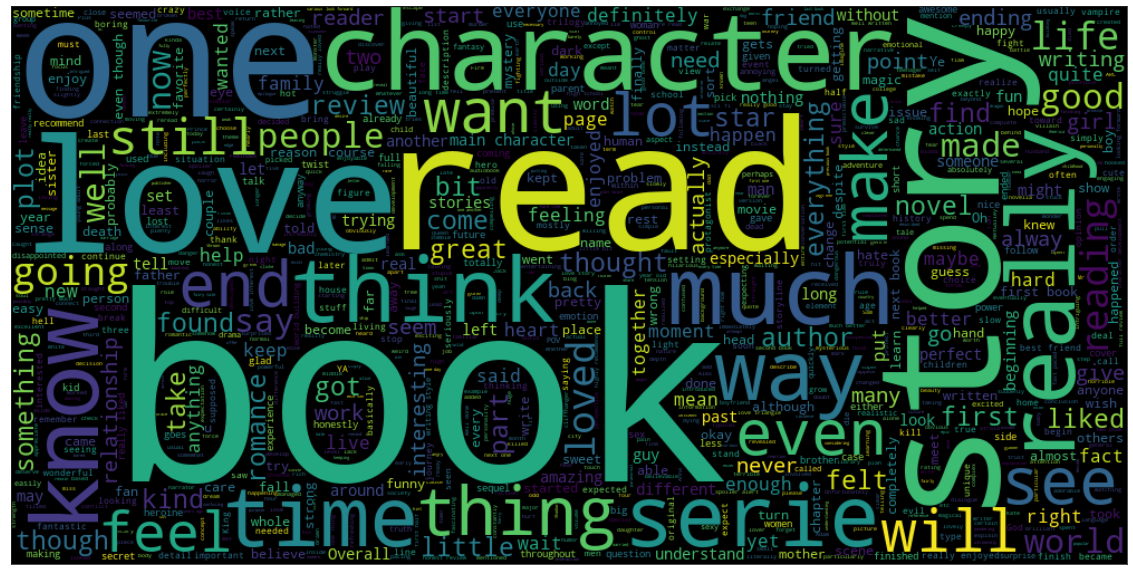

In [ ]:
# Not spoiler sentences wordcloud
wc = WordCloud(max_words=2000, width=1000, height=500)
wc.generate(" ".join(df[df.is_spoiler == 0]["sentence"]))

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation="bilinear")
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text major ticklabel objects>)

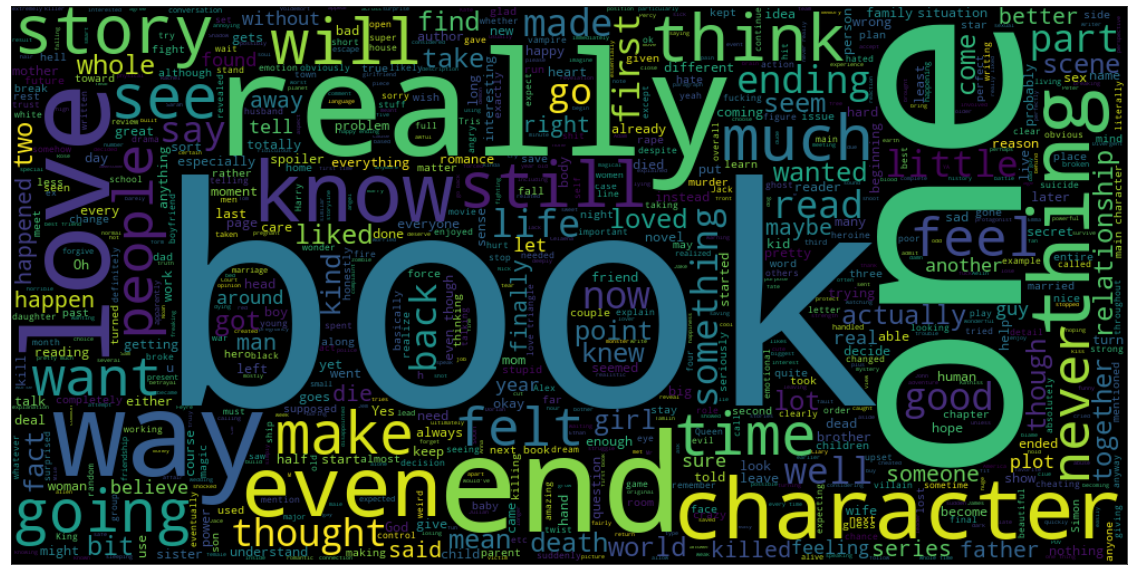

In [ ]:
# Spoiler sentences wordcloud
wc = WordCloud(max_words=2000, width=1000, height=500)
wc.generate(" ".join(df[df.is_spoiler == 1]["sentence"]))

plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation="bilinear")
plt.xticks([])
plt.yticks([])

### Histogram of relative positions of sentences

The skew in the histogram below suggests that spoiler sentences tend to appear later in the review. Hence this feature could be informative for spoiler
classification.

<Figure size 720x360 with 0 Axes>

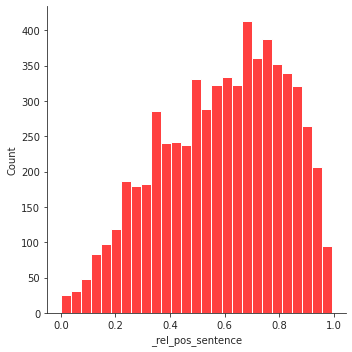

In [ ]:
plt.figure(figsize=(10, 5))

sns.displot(
    data=df[df.is_spoiler == 1], x="_rel_pos_sentence", kind="hist", color="red"
)

### Density plots of the logarithms of the lengths of sentences

Given how marginal the difference is in the plot below, we are skeptical about
the informativeness of this feature. However, we have included it in our models anyways with the understanding that it can be regularized out in the training process if it proves to be redundant.

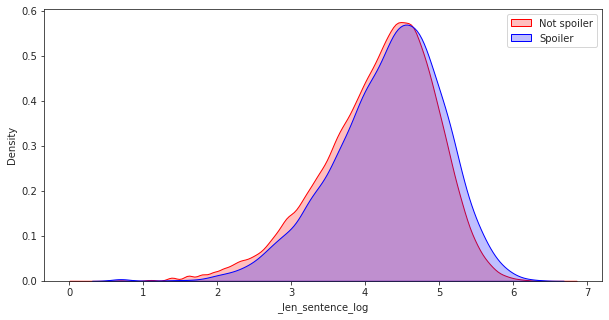

In [ ]:
plt.figure(figsize=(10, 5))

sns.kdeplot(
    data=df[df.is_spoiler == 0], 
    x="_len_sentence_log", 
    shade=True, 
    color="red", 
    label="Not spoiler", 
    clip=[0, 2000]
)
sns.kdeplot(
    data=df[df.is_spoiler == 1], 
    x="_len_sentence_log", 
    shade=True, 
    color="blue", 
    label="Spoiler", 
    clip=[0, 2000]
)

plt.legend(loc="best")

# Utility Functions

We define some utility functions that are used during model training.

In [ ]:
def print_metrics(model, X, y):
    """Prints performance metrics"""
    y_pred = model.predict(X) # Predicted labels
    y_pred_proba = model.predict_proba(X) # Predicted probabilities
    
    # Test accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y, y_pred=y_pred)}\n")
    
    # Classification report
    print(metrics.classification_report(y_true=y, y_pred=y_pred))

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(
        xlabel="Pred", ylabel="True", 
        xticklabels=[0, 1], yticklabels=[0, 1], 
        title="Confusion Matrix"
    )

    # ROC curve/AUC score
    fpr, tpr, thresholds = metrics.roc_curve(
        y_true=y, y_score=y_pred_proba[:, 1], pos_label=1
    )
    auc_score = metrics.roc_auc_score(y_true=y, y_score=y_pred_proba[:, 1])
    ax2.plot(
        fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})"
    )
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

In [ ]:
def print_metrics_hyper(model, X, y):
    """Truncated version of print_metrics for hyperparameter tuning"""
    y_pred = clf.predict(X) # Predicted labels
    y_pred_proba = clf.predict_proba(X) # Predicted probabilities

    accuracy = metrics.accuracy_score(y_true=y, y_pred=y_pred)
    auc_score = metrics.roc_auc_score(y_true=y, y_score=y_pred_proba[:, 1])
    precision, recall, fbeta_score, _ = metrics.precision_recall_fscore_support(
        y_true=y, y_pred=y_pred, average="binary"
    )
    print(f"accuracy: {accuracy:.3f}, auc: {auc_score:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, fbeta_score: {fbeta_score:.3f}")

In [ ]:
def product_dict(**kwargs):
    """Helper function for hyperparameter tuning"""
    keys = kwargs.keys()
    vals = kwargs.values()
    return [dict(zip(keys, instance)) for instance in itertools.product(*vals)] 

# Logistic Regression

We experiment with the following three cases :-

1) Underweighting majority class + Hyperparameter tuning

In [ ]:
class_weights = [{0: w, 1: 1} for w in [0.01, 0.05, 0.1, 0.3, 0.5, 1]]
params = (product_dict(**{
    "penalty": ["elasticnet"], 
    "class_weight": class_weights, 
    "l1_ratio": [0, 0.5, 1]
}))

for param in params:
    penalty = param["penalty"]
    class_weight = param["class_weight"]
    l1_ratio = param["l1_ratio"]

    # Fit model
    clf = LogisticRegression(
        penalty=penalty, 
        class_weight=class_weight, 
        random_state=42, 
        solver="saga", 
        max_iter=1000, 
        l1_ratio=l1_ratio
    )
    clf.fit(X_train_values, y_train_values)

    print(f"penalty: {penalty}, class_weight: {class_weight}, l1_ratio: {l1_ratio}")
    print_metrics_hyper(clf, X_train_values, y_train_values)
    print_metrics_hyper(clf, X_val_values, y_val_values)

2) Undersampling majority class + Hyperparameter tuning

In [ ]:
params = (product_dict(**{
    "sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1], 
    "penalty": ["elasticnet"], 
    "l1_ratio": [0, 0.5, 1]
}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    penalty = param["penalty"]
    l1_ratio = param["l1_ratio"]

    # Undersample majority class
    X_train_rs_values, y_train_rs_values = \
    imblearn.under_sampling.RandomUnderSampler(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)

    # Fit model
    clf = LogisticRegression(
        penalty=penalty, 
        random_state=42, 
        solver="saga", 
        max_iter=1000, 
        l1_ratio=l1_ratio
    )
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, penalty: {penalty}, l1_ratio: {l1_ratio}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

3) Oversampling minority class + Hyperparameter tuning

In [ ]:
params = (product_dict(**{
    "sampling_strategy": [0.05, 0.1, 0.3, 0.5, 1], 
    "penalty": ["elasticnet"], 
    "l1_ratio": [0, 0.5, 1]
}))

for param in params:
    sampling_strategy = param["sampling_strategy"]
    penalty = param["penalty"]
    l1_ratio = param["l1_ratio"]

    # Oversample minority class
    X_train_rs_values, y_train_rs_values = imblearn.over_sampling.SMOTE(
        sampling_strategy=sampling_strategy,
        random_state=42
    ).fit_resample(X_train_values, y_train_values)

    # Fit model
    clf = LogisticRegression(
        penalty=penalty, 
        random_state=42, 
        solver="saga", 
        max_iter=1000, 
        l1_ratio=l1_ratio
    )
    clf.fit(X_train_rs_values, y_train_rs_values)

    print(f"sampling_strategy: {sampling_strategy}, penalty: {penalty}, l1_ratio: {l1_ratio}")
    print_metrics_hyper(clf, X_val_values, y_val_values)

Below we show the metrics for the best performing model

In [ ]:
# Train the model
clf = LogisticRegression(
    penalty="elasticnet", 
    class_weight={0: 0.1, 1: 1}, 
    random_state=42, 
    solver="saga", 
    max_iter=1000, 
    l1_ratio=0.5
)
clf.fit(X_train_values, y_train_values)

LogisticRegression(class_weight={0: 0.1, 1: 1}, l1_ratio=0.5, max_iter=1000,
                   penalty='elasticnet', random_state=42, solver='saga')

Accuracy: 0.917050505050505

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     95750
           1       0.16      0.35      0.21      3250

    accuracy                           0.92     99000
   macro avg       0.57      0.64      0.59     99000
weighted avg       0.95      0.92      0.93     99000



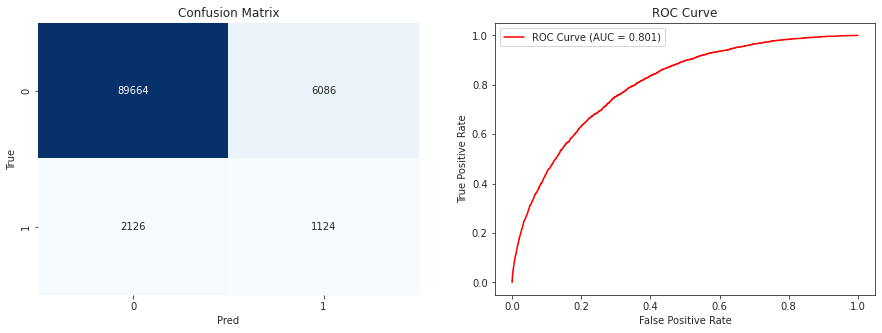

In [ ]:
# Print metrics on train dataset
print_metrics(clf, X_train_values, y_train_values)

Accuracy: 0.91702

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     48488
           1       0.14      0.34      0.20      1512

    accuracy                           0.92     50000
   macro avg       0.56      0.64      0.58     50000
weighted avg       0.95      0.92      0.93     50000



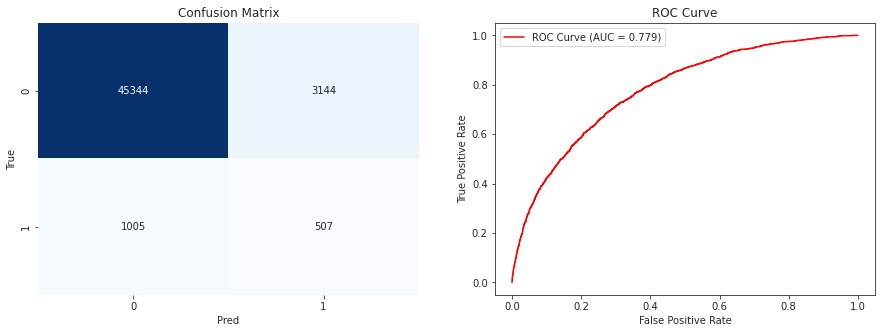

In [ ]:
# Print metrics on val dataset
print_metrics(clf, X_val_values, y_val_values)

Accuracy: 0.91756

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     48468
           1       0.14      0.32      0.19      1532

    accuracy                           0.92     50000
   macro avg       0.56      0.63      0.57     50000
weighted avg       0.95      0.92      0.93     50000



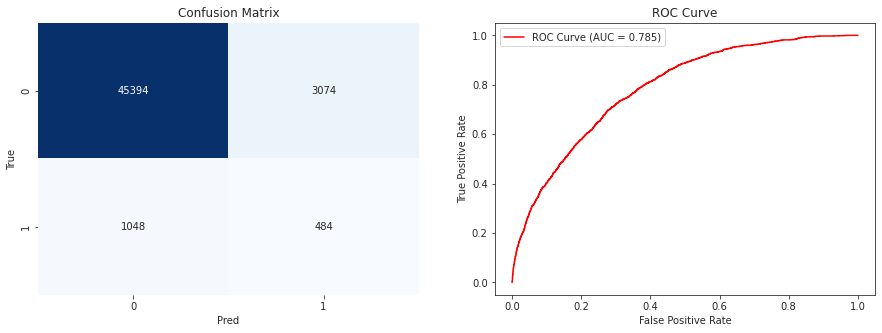

In [ ]:
# Print metrics on test dataset
print_metrics(clf, X_test_values, y_test_values)

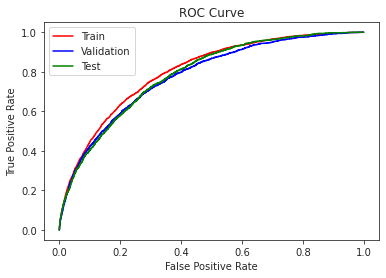

In [ ]:
# Combined ROC curve for train/val/test datasets

y_pred = clf.predict(X_train_values)
y_pred_proba = clf.predict_proba(X_train_values)
fpr, tpr, thresholds = metrics.roc_curve(
    y_true=y_train_values, y_score=y_pred_proba[:, 1], pos_label=1
)
auc_score = metrics.roc_auc_score(
    y_true=y_train_values, y_score=y_pred_proba[:, 1]
)
plt.plot(fpr, tpr, color="red", label=f"Train")

y_pred = clf.predict(X_val_values)
y_pred_proba = clf.predict_proba(X_val_values)
fpr, tpr, thresholds = metrics.roc_curve(
    y_true=y_val_values, y_score=y_pred_proba[:, 1], pos_label=1
)
auc_score = metrics.roc_auc_score(
    y_true=y_val_values, y_score=y_pred_proba[:, 1]
)
plt.plot(fpr, tpr, color="blue", label=f"Validation")

y_pred = clf.predict(X_test_values)
y_pred_proba = clf.predict_proba(X_test_values)
fpr, tpr, thresholds = metrics.roc_curve(
    y_true=y_test_values, y_score=y_pred_proba[:, 1], pos_label=1
)
auc_score = metrics.roc_auc_score(
    y_true=y_test_values, y_score=y_pred_proba[:, 1]
)
plt.plot(fpr, tpr, color="green", label=f"Test")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")